In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Reshape, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [7]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim = 100, activation = LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7,7,128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size = 5, padding = 'same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size = 5, padding = 'same', activation = 'tanh'))

In [12]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size = 5, strides = 2, input_shape = (28,28,1), padding = "same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size = 5, strides = 2, padding = "same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation ='sigmoid'))
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'adam')
discriminator.trainable = False

In [13]:
ginput = Input(shape = (100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer = 'adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_6 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [23]:
def gan_train(epoch, batch_size, saving_interval):
  (X_train, _), (_, _) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5
  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    print('epoch: %d' % i, 'd_loss:%.4f' % d_loss, 'g_loss:%.4f' % g_loss)

    if i % saving_interval == 0:
      noise = np.random.normal(0,1, (25,100))
      gen_imgs = generator.predict(noise)

      gen_imgs = 0.5 * gen_imgs + 0.5
      fig, axs = plt.subplots(5,5)
      count = 0

      for j in range(5):
        for k in range(5):
          axs[j,k].imshow(gen_imgs[count, :, :, 0], cmap = 'gray')
          axs[j,k].axis('off')
          count += 1
      fig.savefig("gan_mnist_%d.png" % i)


epoch: 0 d_loss:0.6563 g_loss:0.0247
epoch: 1 d_loss:0.5949 g_loss:0.1117
epoch: 2 d_loss:0.4866 g_loss:0.3897
epoch: 3 d_loss:0.4804 g_loss:0.6408
epoch: 4 d_loss:0.4830 g_loss:0.7639
epoch: 5 d_loss:0.4624 g_loss:0.8229
epoch: 6 d_loss:0.4417 g_loss:0.8612
epoch: 7 d_loss:0.4032 g_loss:0.8870
epoch: 8 d_loss:0.4104 g_loss:0.8869
epoch: 9 d_loss:0.4316 g_loss:1.0718
epoch: 10 d_loss:0.4837 g_loss:1.2225
epoch: 11 d_loss:0.7567 g_loss:1.2449
epoch: 12 d_loss:0.6645 g_loss:1.3375
epoch: 13 d_loss:0.7380 g_loss:1.1183
epoch: 14 d_loss:0.6168 g_loss:1.0273
epoch: 15 d_loss:0.5841 g_loss:0.8804
epoch: 16 d_loss:0.4722 g_loss:0.7538
epoch: 17 d_loss:0.4592 g_loss:0.6508
epoch: 18 d_loss:0.3850 g_loss:0.6457
epoch: 19 d_loss:0.3495 g_loss:0.7912
epoch: 20 d_loss:0.3707 g_loss:0.8333
epoch: 21 d_loss:0.3242 g_loss:1.0730
epoch: 22 d_loss:0.3876 g_loss:0.9318
epoch: 23 d_loss:0.3500 g_loss:0.8612
epoch: 24 d_loss:0.2890 g_loss:1.1237
epoch: 25 d_loss:0.3143 g_loss:1.1092
epoch: 26 d_loss:0.290

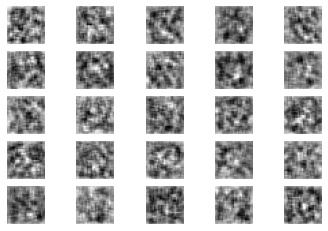

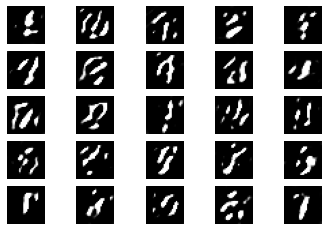

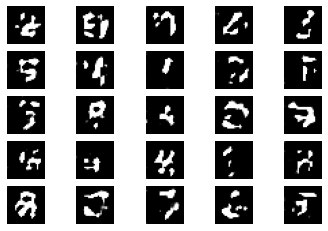

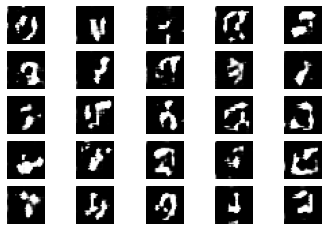

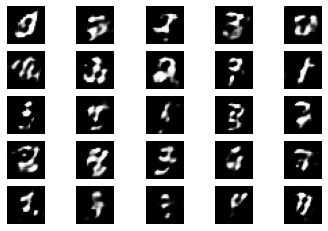

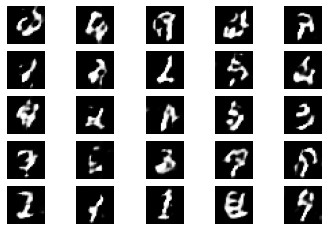

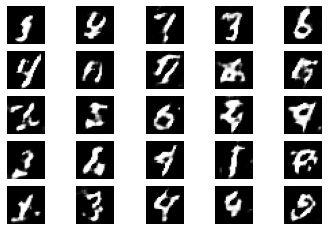

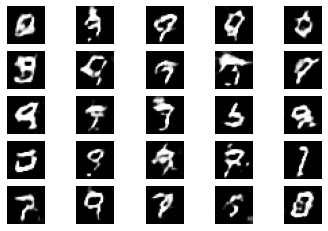

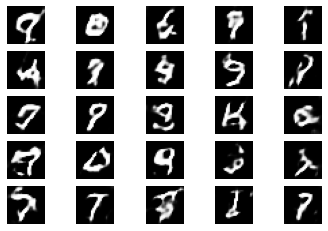

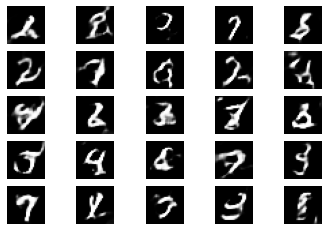

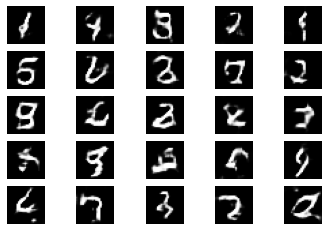

In [24]:
gan_train(2001, 32, 200)